<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multilayered-Neural-Network" data-toc-modified-id="Multilayered-Neural-Network-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multilayered Neural Network</a></span><ul class="toc-item"><li><span><a href="#Required-Part-One" data-toc-modified-id="Required-Part-One-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Required Part One</a></span></li><li><span><a href="#Required-Part-Two" data-toc-modified-id="Required-Part-Two-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Required Part Two</a></span></li></ul></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

# A2.1 Multilayered Neural Network

* 2.1: *Added A2grader.tar and details on how to rename the functions for the use of the asymmetric sigmoid activation function.*

You will implement a set of functions for training and testing a multilayered neural network to predict continuous-valued target values.  This assignment provides an implementation of the functions for a neural network with one hidden layer.  You must modify the functions to allow any number of hidden layers, each with any number of units.

The required functions are:

* `add_ones(X)`: Given an $N \times D$ matrix of inputs, prepend column of 1's and return the resulting $N \times D+1$ matrix.
* `make_weights(n_inputs, n_hiddens, n_outputs):` Given integers `n_inputs`, `n_hiddens` and `n_outputs`, create weight matrices `V` for the hidden layer and `W` for the output layer.
* `forward(Xst, V, W)`: Given standardized input matrix `Xst` and weight matrices `V` and `W`, calculate the output of all layers and return the outputs of the hidden layer, `Z` as an $N \times H$ matrix, where $H$ is the number of hidden units, and the outputs of the output layer `Y` as an $N \times K$ matrix, where $K$ is the number of output values for each sample. 
* `backward(Xst, Tst, V, W)`: Given standardized input matrix `Xst`, standardized target matrix `Tst`, and weight matrices `V` and `W`,, calculate the gradient of the mean squared error with respect to the weights `V` and `W`, returning a tuple of both gradients, with respect to `V` as the first element and with respect to `W` as the second element.
* `train_sgd(X, T, V, W, learning_rate, n_epochs):` Given input and target matrices `X` and `T`, weight matrices `V` and `W`, a learning_rate and the number of epochs to train, update the weights for `n_epochs` iterations using the gradient of the mean squared over the whole data set in `X` and `T`  and return the resulting new weight matrices `V` and `W`, the standardization parameters, and the list of RMSE training errors, one per epoch.
* `use(X, V, W, stand_parms):` Calculate outputs of both layers after standardizing input `X`. Return outputs of hidden layer, and unstandardized output of output layer.
* `rmse(Y, T):` Return the RMSE between `Y` and `T`, both of which are not standardized.
* `calc_standardize_parameters(X, T)`: calculate and return as a dictionary the column means and standard deviations of `X` and `T`.
* `standardize_X(X, stand_parms)`: return standardized `X`.
* `standardize_T(T, stand_parms)`: return standardized `T`.
* `unstandardize_X(Xst, stand_parms)`: return unstandardized `X` (probably not needed).
* `unstandardize_T(Tst, stand_parms)`: return unstandardized `T`, will be needed by `use`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def add_ones(X):
    return np.insert(X, 0, 1, axis=1)

def make_weights(n_inputs, n_hiddens, n_outputs):
    # Create and return weight matrices, V and W, for the hidden and output layers.
    # Initialize them to uniformly-distribted random values between -sqrt(n_in) and +sqrt(n_in)
    V = np.random.uniform(-1, 1, size=(1 + n_inputs, n_hiddens)) / np.sqrt(n_inputs + 1)
    W = np.random.uniform(-1, 1, size=(1 + n_hiddens, n_outputs)) / np.sqrt(n_hiddens + 1)
    return V, W

def forward(Xst, V, W):
    # Calculate the outputs, Z, of all hidden units, given all input samples in X.
    Z = np.tanh(add_ones(Xst) @ V)
    # Calculate the outputs, Y, of all output units, given all outputs of the hidden units.
    Yst = add_ones(Z) @ W
    return Z, Yst

def backward(Xst, Tst, V, W):
    n_samples = Xst.shape[0]
    n_outputs = Tst.shape[1]
    # Calculate the outputs of both layers.
    Z, Yst = forward(Xst, V, W)
    # Calculate the delta value for the output layer. Divide by n_samples * n_outputs
    # because we are calculating the gradient of the mean sqauared error with respect to weights.
    delta = -(Tst - Yst) /  (n_samples * n_outputs)
    # The gradient of the mean squared error with respect to the output layer weights W.
    gradient_W = add_ones(Z).T @ delta
    # Back-propagate the delta value from the output layer, through the output layer weights,
    # to the hidden units.  Multiply the result by the derivative of the hidden units'
    # activation function, tanh
    delta = (delta @ W[1:, :].T) * (1 - Z ** 2)
    # The gradient of the mean squared error with respect to the hidden layer weights, V.
    gradient_V = add_ones(Xst).T @ delta
    # Return both gradients.  Each should be the same shape as the respective weight matrices.
    return gradient_V, gradient_W

def train_sgd(X, T, V, W, learning_rate, n_epochs):
    # Store standardization parameters in dictionary stand_parms.
    stand_parms = calc_standardize_parameters(X, T)
    # Standardize X and T.
    Xst = standardize_X(X, stand_parms)
    Tst = standardize_T(T, stand_parms)

    error_trace = []

    # Update weights for n_epochs passes through the training data
    for epoch in range(n_epochs):

        # Calculate the gradients of the mean squared error with respect to each weight matrix.
        gradient_V, gradient_W = backward(Xst, Tst, V, W)

        # Update the values in each weight matrix using SGD.
        V -= learning_rate * gradient_V
        W -= learning_rate * gradient_W

        # Calculate the outputs of both layers given the current weight values.
        _, Yst = forward(Xst, V, W)
        Y = unstandardize_T(Yst, stand_parms)
        error_trace.append(rmse(Y, T))

    return V, W, stand_parms, error_trace

def use(X, V, W, stand_parms):
    # Standardize inputs X
    Xst = standardize_X(X, stand_parms)
    # Calculate outputs of each layer.
    Z, Yst = forward(Xst, V, W)
    # Unstandardize output of output layer
    return Z, unstandardize_T(Yst, stand_parms)

def rmse(Y, T):
    error = T - Y
    return np.sqrt(np.mean(error ** 2))

In [23]:
def calc_standardize_parameters(X, T):
    Xmeans = X.mean(axis=0)
    Xstds = X.std(axis=0)
    Tmeans = T.mean(axis=0)
    Tstds = T.std(axis=0)
    return {'Xmeans': Xmeans, 'Xstds': Xstds,
            'Tmeans': Tmeans, 'Tstds': Tstds}

def standardize_X(X, stand_parms):
    return (X - stand_parms['Xmeans']) / stand_parms['Xstds']


def unstandardize_X(Xst, stand_parms):
    return Xst * stand_parms['Xstds'] + stand_parms['Xmeans']


def standardize_T(T, stand_parms):
    return (T - stand_parms['Tmeans']) / stand_parms['Tstds']


def unstandardize_T(Tst, stand_parms):
    return Tst * stand_parms['Tstds'] + stand_parms['Tmeans']

Here is a test of the functions.  We fit a neural network to simple one-dimensional data.

In [28]:
n_samples = 30

Xtrain = np.linspace(0., 20.0, n_samples).reshape((n_samples, 1))
Ttrain = 0.2 + 0.05 * (Xtrain) + 0.4 * np.sin(Xtrain / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

Xtest = Xtrain + 0.1 * np.random.normal(size=(n_samples, 1))
Ttest = 0.2 + 0.05 * (Xtest) + 0.4 * np.sin(Xtest / 2) + 0.2 * np.random.normal(size=(n_samples, 1))

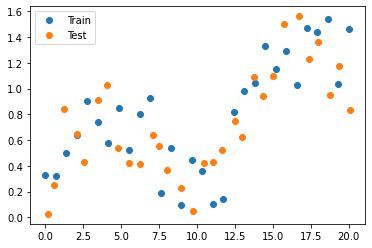

In [29]:
plt.plot(Xtrain, Ttrain, 'o', label='Train')
plt.plot(Xtest, Ttest, 'o', label='Test')
plt.legend();

In [33]:
n_inputs = Xtrain.shape[1]
n_hiddens = 10
n_outputs = Ttrain.shape[1]

n_epochs = 2000
learning_rate = 0.1

V, W = make_weights(n_inputs, n_hiddens, n_outputs)

V, W, stand_parms, error_trace = train_sgd(Xtrain, Ttrain, V, W, learning_rate, n_epochs)

_, Ytrain = use(Xtrain, V, W, stand_parms)  # 
rmse_train = rmse(Ytrain, Ttrain)
_, Ytest = use(Xtest, V, W, stand_parms)
rmse_test = rmse(Ytest, Ttest)

print(f'RMSE: Train {rmse_train:.2f} Test {rmse_test:.2f}')

RMSE: Train 0.18 Test 0.24


In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(error_trace)
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.subplot(3, 1, 2)
plt.plot(Xtrain, Ttrain, 'o', label='Training Data')
plt.plot(Xtest, Ttest, 'o', label='Testing Data')
X_for_plot = np.linspace(0, 20, 100).reshape(-1, 1)
Z_train, Y_train = use(X_for_plot, V, W, stand_parms)
plt.plot(X_for_plot, Y_train, label='Neural Net Output')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(3, 1, 3)
plt.plot(X_for_plot, Z_train)
plt.xlabel('X')
plt.ylabel('Hidden Unit Outputs')

Text(0, 0.5, 'Hidden Unit Outputs')

## Required Part One

The changes you must implement are specified here.  We recommend that you copy the above code cells and paste them below, then edit them appropriately.

You will implement a set of functions for training and testing a multilayered neural network to predict continuous-valued target values.  This assignment provides an implementation of the functions for a neural network with one hidden layer.  You must modify the functions to allow any number of hidden layers, each with any number of units.

The required functions are:

* `make_weights(n_inputs, n_hiddens_list, n_outputs):` Given integers `n_inputs`, list of `n_hiddens`, one integer per hidden layer, and `n_outputs`, create and return list of weight matrices, one for each layer.
* `forward(Xst, Ws)`: Given standardized input matrix `X` and list of weight matrices `Ws`, calculate the output of all layers and return a list of the outputs of each layer.
* `backward(Xst, Tst, Ws)`: Given standardized input matrix `X`, standardized target matrix `T`, and list of weight matrices `Ws`, calculate the gradient of the mean squared error with respect to the weights in each layer, returning a tuple or list of all gradient matrices.
* `train_sgd(X, T, Ws, learning_rate, n_epochs):` Given input and target matrices `X` and `T`, liist of all weight matrices `Ws`, a learning_rate and the number of epochs to train, update the weights for `n_epochs` iterations using the gradient of the mean squared over the whole data set in `X` and `T`  and return the list of resulting new weight matrices, the standardization parameters, and the list of RMSE training errors, one per epoch.
* `use(X, Ws, stand_parms):` Calculate outputs of all layers after standardizing input `X`. Return list of outputs of each hidden layer, and unstandardized output of output layer.

Test your functions on the same one-dimensional data shown above.  Try your code using two hidden layers of as many units in each layer as you wish.  Plot the results, including an additional plot to show the outputs of each of the two hidden layers.

Write a for loop to create and train neural nets containing one, two, three and four hidden layers each with 4 hidden units. Train each for 10,000 epochs and a learning rate of 0.1. Collect list of results with each result being a list containing the number of layers and the RMSE for training and testing data.

Print a pretty table of your results be creating a `pandas` DataFrame of the results list (of lists). Discuss the results.

In [38]:
import pandas
df = pandas.DataFrame(results, columns=('Layers', 'RMSE Train', 'RMSE Test'))
df

Layers  RMSE Train  RMSE Test
0       1    0.159036   0.262594
1       2    0.152369   0.268204
2       3    0.149410   0.270108
3       4    0.152133   0.269085

## Required Part Two

Copy and paste here the following functions and rename them as shown.  These new versions will use the asymmetric sigmoid activation function instead of the symmetric one that used `tanh`.  Repeat the above experiments with the one-dimensional data.

* `forward` becomes `forward_asig`
* `backward` becomes `backward_asig`
* `train_sgd` becomes `train_sgd_asig`
* `use` becomes `use_asig`

# Grading

Your notebook will be run and graded automatically. Test this grading process by first downloading [A2grader.tar](http://www.cs.colostate.edu/~anderson/cs545/notebooks/A2grader.tar) and extract `A2grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  The remaining 40 points will be based on other testing and the results you obtain and your discussions. 

A different, but similar, grading script will be used to grade your checked-in notebook. It will include additional tests. You should design and perform additional tests on all of your functions to be sure they run correctly before checking in your notebook.  

For the grading script to run correctly, you must first name this notebook as 'Lastname-A2.ipynb' with 'Lastname' being your last name, and then save this notebook.

In [14]:
%run -i A2grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Anderson-A2.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

## Testing ####################################################################

    X = np.arange(4).reshape(-1, 1) + 5
    T = np.array([1, 2, -3, -4]).reshape((-1, 1))
    Ws = make_weights(1, [3, 4], 1)
    for W in Ws:
        W[:] = np.linspace(-1, 1, W.size).reshape(W.shape)

    stand_parms = {'Xmeans': np.array([[0]]), 'Xstds': np.array([[1]]),
                   'Tmeans': np.array([[0]]), 'Tstds': np.array([[1]])}

    def print_layers(what, lst):
        print(f'{what}:')
        for (i, element) in enumerate(lst):
            print(f' Layer {i}:')
            print(f' {element}')

    print('X is')
    print(X)
    print_layers('Ws', Ws)
    print('stand_parms is')
    print(stand_parms)
    Ys = use(X, Ws, stand_parms)

X is
 [[5]
 [6]

# Check-In

Do not include this section in your notebook.

Name your notebook ```Lastname-A2.ipynb```.  So, for me it would be ```Anderson-A2.ipynb```.  Submit the file using the ```Assignment 2``` link on [Canvas](https://colostate.instructure.com/courses/109894).

# Extra Credit

Apply your multilayer neural network code to a regression problem using data that you choose 
from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets.php). Pick a dataset that
is listed as being appropriate for regression.